<a href="https://colab.research.google.com/github/aliframadhana03/Star-Sensor-Radial-Based-Machine-Learning/blob/main/Alif_Star_Tracker_3_Catalogue_for_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preliminary

## Star Sensor Flow Chart

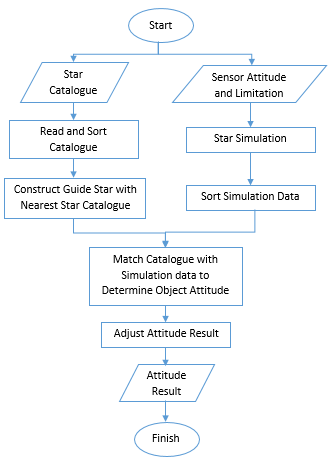

For testing the simulation with certain attitude, section that needed to run are:
1.   Importing Library
2.   Star Catalogue Extraction
3.   Star Simulation
4.   Object Attitude Determination



For iterating simulation data with result as accuracy, section needed to run are:
1.   Importing Library
2.   Star Catalogue Extraction
3.   Iteration for Random Attitude



## Importing Library

In [ ]:
from math import radians,degrees,sin,cos,tan,sqrt,atan,pi,exp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
print("done")

done


# Star Catalogue Extraction

## Importing Star Catalogue

This model uses star catalogue with magnitude below 6 and for stars who have magnitude below 4 will be used as guide star.

For filtered catalogue can be download from link below.

https://drive.google.com/drive/folders/1nYQuHfx167BqTzHbV34uj9IhfACx_nHp?usp=sharing

---



In [ ]:
from google.colab import files
upload = files.upload()

Saving Below_6.0_SAO.csv to Below_6.0_SAO.csv


## Reading and Sorting Star Catalogue

Reading and extracting filtered star catalogue.

In [ ]:
# Reading Filtered Star Catalogue
starCatalogueDegree = []
starCatalogueRadian = pd.read_csv('Below_6.0_SAO.csv')
starCatalogueRadianFiltered = starCatalogueRadian.iloc[: , 1:]

# Converting to Degree
for label, row in starCatalogueRadianFiltered.iterrows():
  StarID    = row['Star ID']
  RADegree  = degrees(row['RA'])
  DEDegree  = degrees(row['DE'])
  Magnitude = row['Magnitude']
  starCatalogueDegree.append([StarID, RADegree, DEDegree, Magnitude])
starCatalogueDegreeFiltered = pd.DataFrame(starCatalogueDegree, columns = ['Star ID', 'RA', 'DE', 'Magnitude'])
starCatalogueDegreeFiltered = starCatalogueDegreeFiltered.sort_values('Magnitude')  # Sorting Catalogue Based on Magnitude
starCatalogueDegreeFiltered = starCatalogueDegreeFiltered.reset_index()
starCatalogueDegreeFiltered

,index,Star ID,RA,DE,Magnitude
0,2955,151880.0,100.736305,-16.646214,-1.6
1,4443,234479.0,95.710388,-52.667625,-0.9
2,1165,67173.0,-81.188937,38.736022,0.1
3,4873,252837.0,-140.953112,-60.630233,0.1
4,670,40185.0,78.247775,45.949456,0.2
...,...,...,...,...,...
5098,3634,192702.0,10.446721,-38.696872,6.0
5099,4424,233475.0,64.357908,-52.980970,6.0
5100,1330,76120.0,55.388680,20.772172,6.0
5101,1374,76971.0,76.232929,21.640439,6.0


## Constructing Guide Star with Nearest Star Catalogue

This star sensor model use subgraph isomorphism method with radial based features. For each guide star, the closest star composition with magnitude below 6 will be searched based on a certain bin degree of certain layers.
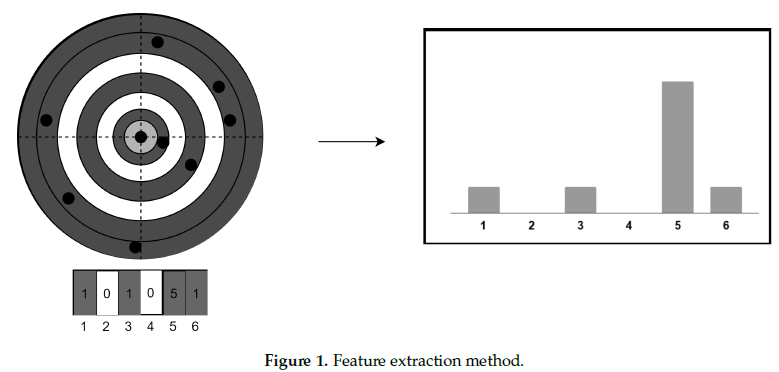

In [ ]:
# Finding the Nearest Star from Guide Star
GuideStarCatalogue = []
bin = 1                                     # Each boundaries has bin degrees differences

for label, row in starCatalogueDegreeFiltered.iterrows():
  if row['Magnitude'] <= 4:
    for x in range(1,8):
      globals()['distance%s' % x] = 0
    for j in range(len(starCatalogueDegreeFiltered.index)):
      R = ((starCatalogueDegreeFiltered.RA[label] - starCatalogueDegreeFiltered.RA[j])**2 + ((starCatalogueDegreeFiltered.DE[label] - starCatalogueDegreeFiltered.DE[j])**2))**0.5  # Range for Each Star
      if R > 0 and R <= bin:                # First Layer
        distance1 = distance1 + 1
      elif R > bin and R <= (bin*2):        # Second Layer
        distance2 = distance2 + 1
      elif R > (bin*2) and R <= (bin*3):    # Third Layer
        distance3 = distance3 + 1
      elif R > (bin*3) and R <= (bin*4):    # Fourth Layer
        distance4 = distance4 + 1
      elif R > (bin*4) and R <= (bin*5):    # Fifth Layer
        distance5 = distance5 + 1
      elif R > (bin*5) and R <= (bin*6):    # Sixth Layer
        distance6 = distance6 + 1
      elif R > (bin*6) and R <= (bin*7):  # Seventh Layer
        distance7 = distance7 + 1
    starID    = row['Star ID']
    RA        = row['RA']
    DE        = row['DE']
    magnitude = row['Magnitude']
    GuideStarCatalogue.append([starID, RA, DE, magnitude, distance1, distance2, distance3, distance4, distance5, distance6, distance7])
    # nearestStar.append([starID, RA, DE, magnitude, distance1, distance2, distance3, distance4, distance5])
    
GuideStarCatalogue = pd.DataFrame(GuideStarCatalogue, columns = ['Star ID', 'RA', 'DE', 'Magnitude', 'distance 1', 'distance 2', 'distance 3', 'distance 4', 'distance 5', 'distance 6', 'distance 7']) # Nearest Star Catalogue
# nearestStarCatalogue = pd.DataFrame(nearestStar, columns = ['Star ID', 'RA', 'DE', 'Magnitude', 'distance 1', 'distance 2', 'distance 3', 'distance 4', 'distance 5']) # Nearest Star Catalogue
# GuideStarCatalogue = nearestStarCatalogue[nearestStarCatalogue['Magnitude'] <= 4]
GuideStarCatalogue


## Testing the Uniqueness of the Nearest Star Catalogue Data
# uniqueData = GuideStarCatalogue.value_counts() # Unique Data
# print(len(uniqueData))

,Star ID,RA,DE,Magnitude,distance 1,distance 2,distance 3,distance 4,distance 5,distance 6,distance 7
0,151880.0,100.736305,-16.646214,-1.6,0,4,5,3,6,3,6
1,234479.0,95.710388,-52.667625,-0.9,1,0,3,1,3,5,4
2,67173.0,-81.188937,38.736022,0.1,1,0,5,2,4,5,5
3,252837.0,-140.953112,-60.630233,0.1,0,0,1,1,4,3,4
4,40185.0,78.247775,45.949456,0.2,0,1,0,1,2,6,4
...,...,...,...,...,...,...,...,...,...,...,...
475,106229.0,-52.294166,11.132175,4.0,1,3,0,3,4,4,5
476,99586.0,170.329709,10.804878,4.0,1,0,0,2,2,5,3
477,146043.0,-25.231583,-1.639936,4.0,0,0,3,3,5,2,5
478,138720.0,-175.663495,-0.389069,4.0,1,0,0,1,1,2,2


# Star Simulation

Simulating star pattern in certain attitude.



## Sensor Limitation

In [ ]:
#length/pixel
myu = 1.12*(10**-6)

#Focal length prompt from user
f = 0.00304

#Star sensor pixel
l = 3280
w = 2464
print("Resolution length: {}".format(l))
print("Resolution width: {}".format(w))

Resolution length: 3280
Resolution width: 2464


## Simulating Star in Certain Attitude

-20
28
FOV y: 48.82609593828837
FOV x: 62.281626767058846
********************************************************************************
Matrix M:
 [[-0.34202014 -0.44115896 -0.82969934]
 [-0.93969262  0.16056873  0.30198586]
 [ 0.          0.88294759 -0.46947156]]
Transpose: [[-0.34202 -0.93969  0.     ]
 [-0.44116  0.16057  0.88295]
 [-0.8297   0.30199 -0.46947]]
Matrix M is orthogonal...
Moving on to next calculation

Reading in CSV file...

0.00010283 1.14878725 0.0
0.00714661 1.0822696000000003 0.0
0.00909513 1.16741462 0.0
0.01092845 1.06527451 0.0
0.01670106 1.11557887 0.0
0.06217918 1.06911229 0.0
0.09606525 1.07432438 0.0
0.13150628 1.09355607 0.0
0.14659399 1.04809097 0.0
0.17041745 1.14971412 0.0
0.20800559 1.11658811 0.0
0.21845698 1.06203988 0.0
0.23418858 1.05499035 0.0
0.23454397 1.04881377 0.0
0.24141374 1.1533558000000002 0.0
0.2640593 1.06127906 0.0
0.26711602 1.07010771 0.0
0.29745567 1.11592135 0.0
0.29849363 1.13016362 0.0
-1.05655076 1.10649196 0.0
-1.04305341 1

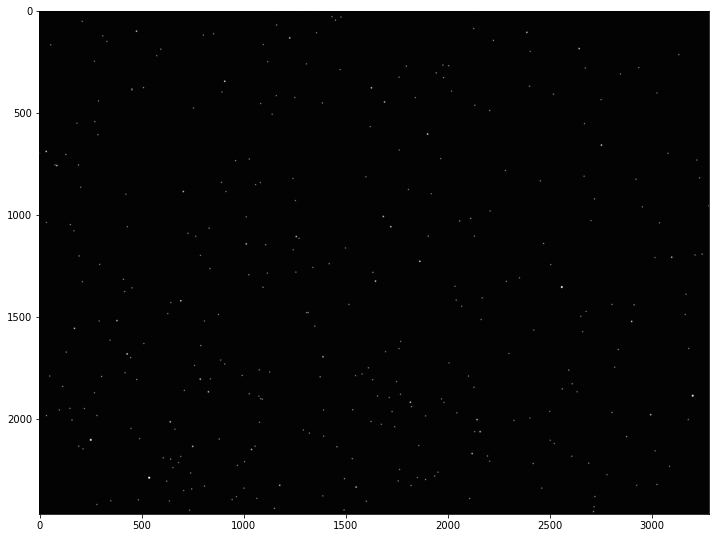

In [ ]:
# Star Simulation Algorithm
def create_M_matrix(ra,de,roll,method=2):
    """[summary]

    Args:
        ra ([int]): [right ascension of sensor center]
        de ([int]): [declination of sensor center]
        roll ([int]): [roll angle of star sensor]
        method ([int]): [1 for method 1(Calculating each elements),2 for method 2(calculating rotation matrices)]
    """
    if method == 1:
        a1 = (sin(ra)*cos(roll)) - (cos(ra)*sin(de)*sin(roll))
        a2 = -(sin(ra)*sin(roll)) - (cos(ra)*sin(de)*cos(roll))
        a3 = -(cos(ra)*cos(de))
        b1 = -(cos(ra)*cos(roll)) - (sin(ra)*sin(de)*sin(roll))
        b2 = (cos(ra)*sin(roll)) - (sin(ra)*sin(de)*cos(roll))
        b3 = -(sin(ra)*cos(de))
        c1 = (cos(ra)*sin(roll))
        c2 = (cos(ra)*cos(roll))
        c3 = -(sin(de))
        M = np.array([[a1,a2,a3],[b1,b2,b3],[c1,c2,c3]])
    if method == 2:
        ra_exp = ra - (pi/2)
        de_exp = de + (pi/2)
        M1 = np.array([[cos(ra_exp),-sin(ra_exp),0],[sin(ra_exp),cos(ra_exp),0],[0,0,1]])
        M2 = np.array([[1,0,0],[0,cos(de_exp),-sin(de_exp)],[0,sin(de_exp),cos(de_exp)]])
        M3 = np.array([[cos(roll),-sin(roll),0],[sin(roll),cos(roll),0],[0,0,1]])
        first_second = np.matmul(M1,M2)
        M = np.matmul(first_second,M3)
    return M


def dir_vector_to_star_sensor(ra,de,M_transpose):
    """[Converts direction vector to star sensor coordinates]

    Args:
        ra ([int]): [right ascension of the object vector]
        de ([int]): [desclination of the object vector]
        M_transpose ([numpy array]): [rotation matrix from direction vector to star sensor transposed]
    """
    print(ra,de,roll)    
    x_dir_vector = (cos(ra)*cos(de))
    y_dir_vector = (sin(ra)*cos(de))
    z_dir_vector = (sin(de))
    dir_vector_matrix = np.array([[x_dir_vector],[y_dir_vector],[z_dir_vector]])
    return M_transpose.dot(dir_vector_matrix)


def draw_star(x,y,magnitude,gaussian,background,ROI=5):
    """[Draws the star in the background image]

    Args:
        x ([int]): [The x coordinate in the image coordinate system (starting from left to right)]
        y ([int]): [The y coordinate in the image coordinate system (starting from top to bottom)]
        magnitude ([float]): [The stellar magnitude]
        gaussian ([bool]): [True if using the gaussian function, false if using own function]
        background ([numpy array]): [background image]
        ROI ([int]): [The ROI of each star in pixel radius]
    """
    if gaussian:
        H = 2000*exp(-magnitude+1)
        sigma = 5
        for u in range(x-ROI,x+ROI+1):
            for v in range(y-ROI,y+ROI+1):
                dist = ((u-x)**2)+((v-y)**2)
                diff = (dist)/(2*(sigma**2))
                exponent_exp = 1/(exp(diff))
                raw_intensity = int(round((H/(2*pi*(sigma**2)))*exponent_exp))
                if u == x and v == y:
                    print(raw_intensity)
                background[v,u] = raw_intensity
    else:
        mag = abs(magnitude-7) #1 until 9
        radius = int(round((mag/9)*(5)+2))
        color = int(round((mag/9)*(155)+100))
        cv2.circle(background,(x,y),radius,color,thickness=-1)
    return background

def add_noise(low,high,background):
    """[Adds noise to an image]

    Args:
        low ([int]): [lower threshold of the noise generated]
        high ([int]): [maximum pixel value of the noise generated]
        background ([numpy array]): [the image that is put noise on]
    """
    row,col = np.shape(background)
    background = background.astype(int)
    noise = np.random.randint(low,high=high,size=(row,col))
    noised_img = cv2.addWeighted(noise,0.1,background,0.9,0)
    return noised_img


def displayImg(img,cmap=None):
    """[Displays image]

    Args:
        img ([numpy array]): [the pixel values in the form of numpy array]
        cmap ([string], optional): [can be 'gray']. Defaults to None.
    """
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)
    plt.show()

#Right ascension, declination and roll input prompt from user
# ra0 = input("Enter the right ascension angle in degrees:\n")
# de0 = input("Enter the declination angle in degrees:\n")
# roll0 = input("Enter the roll angle in degrees:\n")

ra0 = -20
de0 = 28
roll0 = 0
print(ra0)
print(de0)

ra = radians(float(ra0))
de = radians(float(de0))
roll = radians(float(roll0))

#Star sensor FOV
FOVy = degrees(2*atan((myu*w/2)/f))
FOVx = degrees(2*atan((myu*l/2)/f))
print("FOV y: {}".format(FOVy))
print("FOV x: {}".format(FOVx))

#STEP 1: CONVERSION OF CELESTIAL COORDINATE SYSTEM TO STAR SENSOR COORDINATE SYSTEM
M = create_M_matrix(ra,de,roll)
print("*"*80)
print(f"Matrix M:\n {M}")

#Check if matrix is orthogonal
M_inverse = np.round(np.linalg.inv(M),decimals=5)
M_transpose = np.round(np.matrix.transpose(M),decimals=5)
print(f"Transpose: {M_transpose}")
orthogonal_check = []
for row in range(3):
    for column in range(3):
        element_check = M_inverse[row,column] == M_transpose[row,column]
        orthogonal_check.append(element_check)

if all(orthogonal_check):
    print("Matrix M is orthogonal...\nMoving on to next calculation\n")
else:
    print("WARNING: Matrix M is not orthogonal")

#Search for image-able stars
print("Reading in CSV file...\n")
col_list = ["Star ID","RA","DE","Magnitude"]
star_catalogue = pd.read_csv('Below_6.0_SAO.csv',usecols=col_list)
R = (sqrt((radians(FOVx)**2)+(radians(FOVy)**2))/2)
alpha_start = (ra - (R/cos(de)))
alpha_end = (ra + (R/cos(de)))
delta_start = (de - R)
delta_end = (de + R)
star_within_ra_range = (alpha_start <= star_catalogue['RA']) & (star_catalogue['RA'] <= alpha_end)
star_within_de_range = (delta_start <= star_catalogue['DE']) & (star_catalogue['DE'] <= delta_end)
star_in_ra = star_catalogue[star_within_ra_range]
star_in_de = star_catalogue[star_within_de_range]
star_in_de = star_in_de[['Star ID']].copy()
stars_within_FOV = pd.merge(star_in_ra,star_in_de,on="Star ID")

#Converting to star sensor coordinate system
ra_i = list(stars_within_FOV['RA'])
de_i = list(stars_within_FOV['DE'])
star_sensor_coordinates = []
for i in range(len(ra_i)):
    coordinates = dir_vector_to_star_sensor(ra_i[i],de_i[i],M_transpose=M_transpose)
    star_sensor_coordinates.append(coordinates)

#STEP 2: CONVERSION OF STAR SENSOR COORDINATE SYSTEM TO IMAGE COORDINATE SYSTEM
star_loc = []
for coord in star_sensor_coordinates:
    x = f*(coord[0]/coord[2])
    y = f*(coord[1]/coord[2])
    star_loc.append((x,y))

pixel_per_length = 1/myu

magnitude_mv = list(stars_within_FOV['Magnitude'])
filtered_magnitude = []

#Rescaling to pixel sizes
pixel_coordinates = []
delete_indices = []
for i,(x1,y1) in enumerate(star_loc):
    x1 = float(x1)
    y1 = float(y1)
    x1pixel = round(pixel_per_length*x1)
    y1pixel = round(pixel_per_length*y1)
    if abs(x1pixel) > l/2 or abs(y1pixel) > w/2:
        delete_indices.append(i)
        continue
    pixel_coordinates.append((x1pixel,y1pixel))
    filtered_magnitude.append(magnitude_mv[i])

background = np.zeros((w,l))
for i in range(len(filtered_magnitude)):
    x = round(l/2 + pixel_coordinates[i][0])
    y = round(w/2 - pixel_coordinates[i][1])
    background = draw_star(x,y,filtered_magnitude[i],False,background)

#Adding noise
background = add_noise(0,50,background=background)

displayImg(background,cmap='gray')

file_name = f"ra{ra0}_de{de0}_roll{roll0}.jpg"
# cv2.imwrite("sample_images/"+file_name,background)
# cv2.imwrite(file_name,background)

Degree limitation from camera focal length and star sensor resolution.

In [ ]:
print(R)
print(FOVx, FOVy)
print(degrees(alpha_start))
print(degrees(alpha_end))
print(degrees(delta_start))
print(degrees(delta_end))

0.6906184639582963
62.281626767058846 48.82609593828837
-39.56952323861813
39.56952323861813
-39.56952323861813
39.56952323861813


## Sorting Simulation Data

Sorting simulation data based on stars magnitude.

In [ ]:
# Star List in FOV Area

stars_within_FOVDegree = []
for label, row in stars_within_FOV.iterrows():
  StarID    = row['Star ID']
  RADegree  = degrees(row['RA'])
  DEDegree  = degrees(row['DE'])
  Magnitude = row['Magnitude']
  stars_within_FOVDegree.append([StarID, RADegree, DEDegree, Magnitude])
stars_within_FOVDegree = pd.DataFrame(stars_within_FOVDegree, columns = ['Star ID', 'RA', 'DE', 'Magnitude'])
stars_within_FOVDegree = stars_within_FOVDegree.sort_values('Magnitude')
stars_within_FOVDegree = stars_within_FOVDegree.reset_index()
stars_within_FOVDegree.drop(['index'], axis = 1)

,Star ID,RA,DE,Magnitude
0,125121.0,-62.914208,8.734919,0.9
1,49940.0,-50.068587,45.100867,1.3
2,73764.0,1.449337,28.814478,2.1
3,49527.0,-54.891971,40.095717,2.3
4,54470.0,16.731067,35.356039,2.4
...,...,...,...,...
679,107339.0,-34.973554,10.595689,6.0
680,35898.0,-1.739116,57.133891,6.0
681,106746.0,-45.456320,19.134228,6.0
682,143893.0,-62.143778,-8.705550,6.0


# Object Attitude Determination

Matching simulation result with star catalogue to determine object attitude.

In [ ]:
nearestStarSimulation = []

for label, row in stars_within_FOVDegree.iterrows():
  if radians(row['RA']) <= (alpha_end - radians(bin)) and radians(row['RA']) >= (alpha_start + radians(bin)) and radians(row['DE']) <= (delta_end - radians(bin)) and radians(row['DE']) >= (delta_start + radians(bin)) and row['Magnitude'] <= 4:
    for x in range(1,6):
      globals()['distance%s' % x] = 0
    for j in range(len(stars_within_FOVDegree.index)):
      R = ((stars_within_FOVDegree.RA[label] - stars_within_FOVDegree.RA[j])**2 + ((stars_within_FOVDegree.DE[label] - stars_within_FOVDegree.DE[j])**2))**0.5  # Range for Each Star
      if R > 0 and R <= bin:              # First Layer
        distance1 = distance1 + 1
      elif R > bin and R <= (bin*2):      # Second Layer
        distance2 = distance2 + 1
      elif R > (bin*2) and R <= (bin*3):  # Third Layer
        distance3 = distance3 + 1
      elif R > (bin*3) and R <= (bin*4):  # Fourth Layer
        distance4 = distance4 + 1
      elif R > (bin*4) and R <= (bin*5):  # Fifth Layer
        distance5 = distance5 + 1
    RAFromCenter = row['RA'] - float(ra0)
    DEFromCenter = row['DE'] - float(de0)
    print('Guide Star ID: \n', row['Star ID'])
    print('Guide Star Distance from Center FOV: \n', RAFromCenter, DEFromCenter)
    print('Guide Nearest Star Compotition: \n', distance1, distance2, distance3, distance4, distance5)

    for label, row in GuideStarCatalogue.iterrows():
      if row['distance 1'] == distance1 and row['distance 2'] == distance2 and row['distance 3'] == distance3 and row['distance 4'] == distance4 and row['distance 5'] == distance5:
        RAAttitude = row['RA'] - RAFromCenter
        DEAttitude = row['DE'] - DEFromCenter
        print('\n Guide Star Attitude:\n', row['RA'], row['DE'])
        print('\n Object Attitude:\n', RAAttitude, DEAttitude)
        break
      # else:
      #   # print('false')
      #   # break
    break

Guide Star ID: 
 125121.0
Guide Star Distance from Center FOV: 
 -42.91420766283974 -19.26508079631411
Guide Nearest Star Compotition: 
 1 3 4 1 0


In [ ]:
print(distance1, distance2, distance3, distance4, distance5)

for label, row in GuideStarCatalogue.iterrows():
    if row['Magnitude'] == -0.9:
      RAAttitude = row['RA'] - RAFromCenter
      DEAttitude = row['DE'] - DEFromCenter
      print('\n Guide Star Attitude:\n', row['RA'], row['DE'])
      print('\n Object Attitude:\n', RAAttitude, DEAttitude)
      break
    # else:
    #   print('false')
    #   break

1 3 4 1 0

 Guide Star Attitude:
 95.7103880595148 -52.66762526037044

 Object Attitude:
 138.62459572235454 -33.402544464056334


In [ ]:
GuideStarCatalogue

,Star ID,RA,DE,Magnitude,distance 1,distance 2,distance 3,distance 4,distance 5,distance 6,distance 7
0,151880.0,100.736305,-16.646214,-1.6,0,4,5,3,6,3,6
1,234479.0,95.710388,-52.667625,-0.9,1,0,3,1,3,5,4
2,67173.0,-81.188937,38.736022,0.1,1,0,5,2,4,5,5
3,252837.0,-140.953112,-60.630233,0.1,0,0,1,1,4,3,4
4,40185.0,78.247775,45.949456,0.2,0,1,0,1,2,6,4
...,...,...,...,...,...,...,...,...,...,...,...
475,106229.0,-52.294166,11.132175,4.0,1,3,0,3,4,4,5
476,99586.0,170.329709,10.804878,4.0,1,0,0,2,2,5,3
477,146043.0,-25.231583,-1.639936,4.0,0,0,3,3,5,2,5
478,138720.0,-175.663495,-0.389069,4.0,1,0,0,1,1,2,2


# Iteration for Random Attitude

Sample number for iteration

In [ ]:
# Iteration
sampleNumber = 50         # Sample Number

Simulation Iteration

In [ ]:
# Star Simulation Algorithm
def create_M_matrix(ra,de,roll,method=2):
    """[summary]

    Args:
        ra ([int]): [right ascension of sensor center]
        de ([int]): [declination of sensor center]
        roll ([int]): [roll angle of star sensor]
        method ([int]): [1 for method 1(Calculating each elements),2 for method 2(calculating rotation matrices)]
    """
    if method == 1:
        a1 = (sin(ra)*cos(roll)) - (cos(ra)*sin(de)*sin(roll))
        a2 = -(sin(ra)*sin(roll)) - (cos(ra)*sin(de)*cos(roll))
        a3 = -(cos(ra)*cos(de))
        b1 = -(cos(ra)*cos(roll)) - (sin(ra)*sin(de)*sin(roll))
        b2 = (cos(ra)*sin(roll)) - (sin(ra)*sin(de)*cos(roll))
        b3 = -(sin(ra)*cos(de))
        c1 = (cos(ra)*sin(roll))
        c2 = (cos(ra)*cos(roll))
        c3 = -(sin(de))
        M = np.array([[a1,a2,a3],[b1,b2,b3],[c1,c2,c3]])
    if method == 2:
        ra_exp = ra - (pi/2)
        de_exp = de + (pi/2)
        M1 = np.array([[cos(ra_exp),-sin(ra_exp),0],[sin(ra_exp),cos(ra_exp),0],[0,0,1]])
        M2 = np.array([[1,0,0],[0,cos(de_exp),-sin(de_exp)],[0,sin(de_exp),cos(de_exp)]])
        M3 = np.array([[cos(roll),-sin(roll),0],[sin(roll),cos(roll),0],[0,0,1]])
        first_second = np.matmul(M1,M2)
        M = np.matmul(first_second,M3)
    return M


def dir_vector_to_star_sensor(ra,de,M_transpose):
    """[Converts direction vector to star sensor coordinates]

    Args:
        ra ([int]): [right ascension of the object vector]
        de ([int]): [desclination of the object vector]
        M_transpose ([numpy array]): [rotation matrix from direction vector to star sensor transposed]
    """
    print(ra,de,roll)    
    x_dir_vector = (cos(ra)*cos(de))
    y_dir_vector = (sin(ra)*cos(de))
    z_dir_vector = (sin(de))
    dir_vector_matrix = np.array([[x_dir_vector],[y_dir_vector],[z_dir_vector]])
    return M_transpose.dot(dir_vector_matrix)


def draw_star(x,y,magnitude,gaussian,background,ROI=5):
    """[Draws the star in the background image]

    Args:
        x ([int]): [The x coordinate in the image coordinate system (starting from left to right)]
        y ([int]): [The y coordinate in the image coordinate system (starting from top to bottom)]
        magnitude ([float]): [The stellar magnitude]
        gaussian ([bool]): [True if using the gaussian function, false if using own function]
        background ([numpy array]): [background image]
        ROI ([int]): [The ROI of each star in pixel radius]
    """
    if gaussian:
        H = 2000*exp(-magnitude+1)
        sigma = 5
        for u in range(x-ROI,x+ROI+1):
            for v in range(y-ROI,y+ROI+1):
                dist = ((u-x)**2)+((v-y)**2)
                diff = (dist)/(2*(sigma**2))
                exponent_exp = 1/(exp(diff))
                raw_intensity = int(round((H/(2*pi*(sigma**2)))*exponent_exp))
                if u == x and v == y:
                    print(raw_intensity)
                background[v,u] = raw_intensity
    else:
        mag = abs(magnitude-7) #1 until 9
        radius = int(round((mag/9)*(5)+2))
        color = int(round((mag/9)*(155)+100))
        cv2.circle(background,(x,y),radius,color,thickness=-1)
    return background

def add_noise(low,high,background):
    """[Adds noise to an image]

    Args:
        low ([int]): [lower threshold of the noise generated]
        high ([int]): [maximum pixel value of the noise generated]
        background ([numpy array]): [the image that is put noise on]
    """
    row,col = np.shape(background)
    background = background.astype(int)
    noise = np.random.randint(low,high=high,size=(row,col))
    noised_img = cv2.addWeighted(noise,0.1,background,0.9,0)
    return noised_img


def displayImg(img,cmap=None):
    """[Displays image]

    Args:
        img ([numpy array]): [the pixel values in the form of numpy array]
        cmap ([string], optional): [can be 'gray']. Defaults to None.
    """
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)
    plt.show()

print("Attitude Comparation:\n (Input RA, input DE, input roll, Result RA, Result DE, Comparation) \n")

# Iteration
trueValue = sampleNumber
for i in range (0,sampleNumber):
  ra0 = random.uniform(0, 180)
  de0 = random.uniform(0,90)
  roll0 = 0
  # print(ra0,de0, roll0)

#Right ascension, declination and roll input prompt from user
# ra0 = input("Enter the right ascension angle in degrees:\n")
# de0 = input("Enter the declination angle in degrees:\n")
# roll0 = input("Enter the roll angle in degrees:\n")

# ra0 = starCatalogueFilteredGuideStar.loc[432,'RA']
# de0 = starCatalogueFilteredGuideStar.loc[432,'DE']
# roll0 = 0
# print(ra0)
# print(de0)

  ra = radians(float(ra0))
  de = radians(float(de0))
  roll = radians(float(roll0))

#length/pixel
  myu = 1.12*(10**-6)

#Focal length prompt from user
  f = 0.00304

#Star sensor pixel
  l = 3280
  w = 2464
  # print("Resolution length: {}".format(l))
  # print("Resolution width: {}".format(w))

#Star sensor FOV
  FOVy = degrees(2*atan((myu*w/2)/f))
  FOVx = degrees(2*atan((myu*l/2)/f))
  # print("FOV y: {}".format(FOVy))
  # print("FOV x: {}".format(FOVx))

#STEP 1: CONVERSION OF CELESTIAL COORDINATE SYSTEM TO STAR SENSOR COORDINATE SYSTEM
  M = create_M_matrix(ra,de,roll)
  # print("*"*80)
  # print(f"Matrix M:\n {M}")

#Check if matrix is orthogonal
  M_inverse = np.round(np.linalg.inv(M),decimals=5)
  M_transpose = np.round(np.matrix.transpose(M),decimals=5)
  # print(f"Transpose: {M_transpose}")
  orthogonal_check = []
  for row in range(3):
      for column in range(3):
          element_check = M_inverse[row,column] == M_transpose[row,column]
          orthogonal_check.append(element_check)

  # if all(orthogonal_check):
  #     print("Matrix M is orthogonal...\nMoving on to next calculation\n")
  # else:
  #     print("WARNING: Matrix M is not orthogonal")

#Search for image-able stars
  # print("Reading in CSV file...\n")
  col_list = ["Star ID","RA","DE","Magnitude"]
  star_catalogue = pd.read_csv('Below_6.0_SAO.csv',usecols=col_list)
  R = (sqrt((radians(FOVx)**2)+(radians(FOVy)**2))/2)
  alpha_start = (ra - (R/cos(de)))
  alpha_end = (ra + (R/cos(de)))
  delta_start = (de - R)
  delta_end = (de + R)
  star_within_ra_range = (alpha_start <= star_catalogue['RA']) & (star_catalogue['RA'] <= alpha_end)
  star_within_de_range = (delta_start <= star_catalogue['DE']) & (star_catalogue['DE'] <= delta_end)
  star_in_ra = star_catalogue[star_within_ra_range]
  star_in_de = star_catalogue[star_within_de_range]
  star_in_de = star_in_de[['Star ID']].copy()
  stars_within_FOV = pd.merge(star_in_ra,star_in_de,on="Star ID")

# Star List in FOV Area

  stars_within_FOVDegree = []
  for label, row in stars_within_FOV.iterrows():
    StarID    = row['Star ID']
    RADegree  = degrees(row['RA'])
    DEDegree  = degrees(row['DE'])
    Magnitude = row['Magnitude']
    stars_within_FOVDegree.append([StarID, RADegree, DEDegree, Magnitude])
  stars_within_FOVDegree = pd.DataFrame(stars_within_FOVDegree, columns = ['Star ID', 'RA', 'DE', 'Magnitude'])
  stars_within_FOVDegree = stars_within_FOVDegree.sort_values('Magnitude')
  stars_within_FOVDegree = stars_within_FOVDegree.reset_index()
  stars_within_FOVDegree

# nearestStar Simulation
  nearestStarSimulation = []

  for label, row in stars_within_FOVDegree.iterrows():
    if radians(row['RA']) <= (alpha_end - radians(bin)) and radians(row['RA']) >= (alpha_start + radians(bin)) and radians(row['DE']) <= (delta_end - radians(bin)) and radians(row['DE']) >= (delta_start + radians(bin)) and row['Magnitude'] <= 4:
      for x in range(1,8):
        globals()['distance%s' % x] = 0
      for j in range(len(stars_within_FOVDegree.index)):
        R = ((stars_within_FOVDegree.RA[label] - stars_within_FOVDegree.RA[j])**2 + ((stars_within_FOVDegree.DE[label] - stars_within_FOVDegree.DE[j])**2))**0.5  # Range for Each Star
        if R > 0 and R <= bin:            # First Layer
          distance1 = distance1 + 1
        elif R > bin and R <= (bin*2):      # Second Layer
          distance2 = distance2 + 1
        elif R > (bin*2) and R <= (bin*3):  # Third Layer
          distance3 = distance3 + 1
        elif R > (bin*3) and R <= (bin*4):  # Fourth Layer
          distance4 = distance4 + 1
        elif R > (bin*4) and R <= (bin*5):  # Fifth Layer
          distance5 = distance5 + 1
        elif R > (bin*5) and R <= (bin*6):  # Sixth Layer
          distance6 = distance6 + 1
        elif R > (bin*6) and R <= (bin*7):  # Seventh Layer
          distance7 = distance7 + 1
      RAFromCenter = row['RA'] - float(ra0)
      DEFromCenter = row['DE'] - float(de0)
      # print(RAFromCenter, DEFromCenter)

      for label, row in GuideStarCatalogue.iterrows():
        if row['distance 1'] == distance1 and row['distance 2'] == distance2 and row['distance 3'] == distance3 and row['distance 4'] == distance4 and row['distance 5'] == distance5 and row['distance 6'] == distance6 and row['distance 7'] == distance7:
        # if row['distance 1'] == distance1 and row['distance 2'] == distance2 and row['distance 3'] == distance3:
          RAAttitude = row['RA'] - RAFromCenter
          DEAttitude = row['DE'] - DEFromCenter
          # print(row['RA'], row['DE'])
          # print(RAAttitude, DEAttitude)
          break
      break
  
  if abs(RAAttitude - ra0) < 0.05 and abs(DEAttitude - de0) < 0.05: # Tingkat ketelitian
    attitude = 'true'
  else:
    attitude = 'false'
    trueValue = trueValue - 1
  print(ra0, de0, roll0, RAAttitude, DEAttitude, attitude)

accuracy = 100*trueValue/sampleNumber
print("\n Accuracy:", accuracy, "%")

Attitude Comparation:
 (Input RA, input DE, input roll, Result RA, Result DE, Comparation) 

131.59051029435204 19.75916725196208 0 138.62459572235454 -33.402544464056334 false
82.84884254441188 88.9349679249704 0 82.8488425444119 88.9349679249704 true
145.51225560125175 34.618724357601614 0 145.51225560125175 34.618724357601614 true
84.69336756324115 87.92748471263856 0 84.69336756324114 87.92748471263856 true
130.0362221737088 4.100392661193851 0 130.0362221737088 4.100392661193851 true
47.23212798411728 32.95080179391576 0 47.23212798411728 32.95080179391576 true
64.17612717481009 23.19330626245564 0 64.17612717481009 23.19330626245564 true
74.79788590749446 42.27931828580738 0 74.79788590749446 42.27931828580738 true
79.73558409959922 85.26122507348688 0 79.73558409959921 85.26122507348688 true
100.42155486399089 59.406147006070626 0 100.42155486399089 59.406147006070626 true
174.02069247072552 1.201539672930808 0 174.02069247072552 1.2015396729308083 true
36.49601815705614 53.7132

# Others

## Missing Star

In [ ]:
# Separating Data
GuideStar = starCatalogueRadianFiltered[starCatalogueRadianFiltered['Magnitude'] <= 4]
NonGuideStar = starCatalogueRadianFiltered[starCatalogueRadianFiltered['Magnitude'] > 4]
# GuideStar = GuideStar.drop(['index'], axis = 1)
# NonGuideStar = NonGuideStar.drop(['index'], axis = 1)

# Deleting Random Non Guide Star Data
np.random.seed(10)
remove_n = 462
drop_indices = np.random.choice(NonGuideStar.index, remove_n, replace=False)
MissingStar = NonGuideStar.drop(drop_indices)

# Merging Data
starCatalogueWithMissingStar = pd.concat([GuideStar, MissingStar])
starCatalogueWithMissingStar

,Star ID,RA,DE,Magnitude
2,307,0.474787,1.553846,2.1
74,7592,-3.004762,1.222841,3.9
80,8101,-2.396217,1.297825,2.2
82,8219,-2.265485,1.256845,3.1
97,9086,-1.474987,1.269059,3.7
...,...,...,...,...
5098,258940,-0.344382,-1.424969,4.3
5099,258945,-0.323709,-1.403046,5.5
5100,258969,-0.168557,-1.531659,5.6
5101,258988,-0.046949,-1.436351,5.1


0
0
FOV y: 48.82609593828837
FOV x: 62.281626767058846
********************************************************************************
Matrix M:
 [[ 6.12323400e-17  6.12323400e-17 -1.00000000e+00]
 [-1.00000000e+00  3.74939946e-33 -6.12323400e-17]
 [ 0.00000000e+00  1.00000000e+00  6.12323400e-17]]
Transpose: [[ 0. -1.  0.]
 [ 0.  0.  1.]
 [-1. -0.  0.]]
Matrix M is orthogonal...
Moving on to next calculation

0.15990547 0.53385642 0.0
0.23548565 0.66721508 0.0
0.29201220000000006 0.61707929 0.0
0.55222065 0.60653353 0.0
0.02529571 0.50290751 0.0
0.48094294 0.51201241 0.0
0.48813515 0.3589177 0.0
0.5425732 0.405387 0.0
-0.5031758 0.43808108 0.0
-0.34621048 0.52288814 0.0
-0.31596342 0.42476329999999995 0.0
-0.25592563 0.48539764 0.0
0.0465019 0.26015379 0.0
0.38747743 0.26334783 0.0
-0.3535749 0.18447835 0.0
-0.25190475 0.26068 0.0
0.68467704 0.00198774 0.0
-0.60331988 0.1683355 0.0
-0.49010299999999996 0.10386711 0.0
-0.19821624 0.05251332 0.0
-0.01421766 0.11495616 0.0
0.07365173 -0

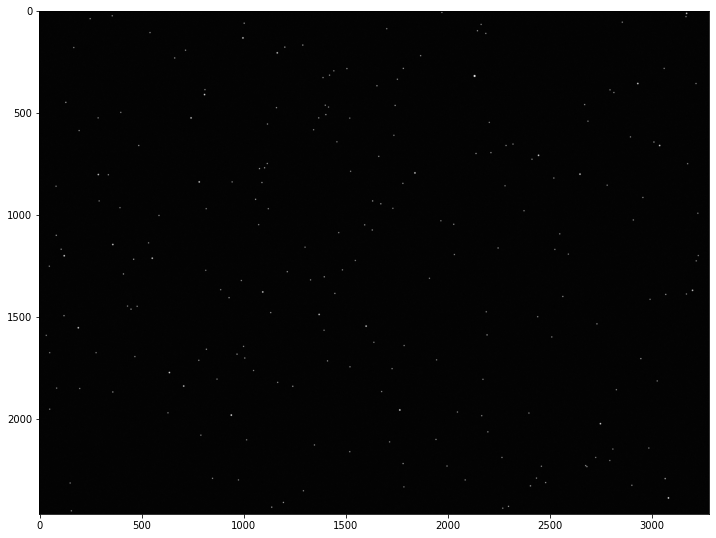

In [ ]:
# Star Simulation Algorithm
def create_M_matrix(ra,de,roll,method=2):
    """[summary]

    Args:
        ra ([int]): [right ascension of sensor center]
        de ([int]): [declination of sensor center]
        roll ([int]): [roll angle of star sensor]
        method ([int]): [1 for method 1(Calculating each elements),2 for method 2(calculating rotation matrices)]
    """
    if method == 1:
        a1 = (sin(ra)*cos(roll)) - (cos(ra)*sin(de)*sin(roll))
        a2 = -(sin(ra)*sin(roll)) - (cos(ra)*sin(de)*cos(roll))
        a3 = -(cos(ra)*cos(de))
        b1 = -(cos(ra)*cos(roll)) - (sin(ra)*sin(de)*sin(roll))
        b2 = (cos(ra)*sin(roll)) - (sin(ra)*sin(de)*cos(roll))
        b3 = -(sin(ra)*cos(de))
        c1 = (cos(ra)*sin(roll))
        c2 = (cos(ra)*cos(roll))
        c3 = -(sin(de))
        M = np.array([[a1,a2,a3],[b1,b2,b3],[c1,c2,c3]])
    if method == 2:
        ra_exp = ra - (pi/2)
        de_exp = de + (pi/2)
        M1 = np.array([[cos(ra_exp),-sin(ra_exp),0],[sin(ra_exp),cos(ra_exp),0],[0,0,1]])
        M2 = np.array([[1,0,0],[0,cos(de_exp),-sin(de_exp)],[0,sin(de_exp),cos(de_exp)]])
        M3 = np.array([[cos(roll),-sin(roll),0],[sin(roll),cos(roll),0],[0,0,1]])
        first_second = np.matmul(M1,M2)
        M = np.matmul(first_second,M3)
    return M


def dir_vector_to_star_sensor(ra,de,M_transpose):
    """[Converts direction vector to star sensor coordinates]

    Args:
        ra ([int]): [right ascension of the object vector]
        de ([int]): [desclination of the object vector]
        M_transpose ([numpy array]): [rotation matrix from direction vector to star sensor transposed]
    """
    print(ra,de,roll)    
    x_dir_vector = (cos(ra)*cos(de))
    y_dir_vector = (sin(ra)*cos(de))
    z_dir_vector = (sin(de))
    dir_vector_matrix = np.array([[x_dir_vector],[y_dir_vector],[z_dir_vector]])
    return M_transpose.dot(dir_vector_matrix)


def draw_star(x,y,magnitude,gaussian,background,ROI=5):
    """[Draws the star in the background image]

    Args:
        x ([int]): [The x coordinate in the image coordinate system (starting from left to right)]
        y ([int]): [The y coordinate in the image coordinate system (starting from top to bottom)]
        magnitude ([float]): [The stellar magnitude]
        gaussian ([bool]): [True if using the gaussian function, false if using own function]
        background ([numpy array]): [background image]
        ROI ([int]): [The ROI of each star in pixel radius]
    """
    if gaussian:
        H = 2000*exp(-magnitude+1)
        sigma = 5
        for u in range(x-ROI,x+ROI+1):
            for v in range(y-ROI,y+ROI+1):
                dist = ((u-x)**2)+((v-y)**2)
                diff = (dist)/(2*(sigma**2))
                exponent_exp = 1/(exp(diff))
                raw_intensity = int(round((H/(2*pi*(sigma**2)))*exponent_exp))
                if u == x and v == y:
                    print(raw_intensity)
                background[v,u] = raw_intensity
    else:
        mag = abs(magnitude-7) #1 until 9
        radius = int(round((mag/9)*(5)+2))
        color = int(round((mag/9)*(155)+100))
        cv2.circle(background,(x,y),radius,color,thickness=-1)
    return background

def add_noise(low,high,background):
    """[Adds noise to an image]

    Args:
        low ([int]): [lower threshold of the noise generated]
        high ([int]): [maximum pixel value of the noise generated]
        background ([numpy array]): [the image that is put noise on]
    """
    row,col = np.shape(background)
    background = background.astype(int)
    noise = np.random.randint(low,high=high,size=(row,col))
    noised_img = cv2.addWeighted(noise,0.1,background,0.9,0)
    return noised_img


def displayImg(img,cmap=None):
    """[Displays image]

    Args:
        img ([numpy array]): [the pixel values in the form of numpy array]
        cmap ([string], optional): [can be 'gray']. Defaults to None.
    """
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)
    plt.show()

#Right ascension, declination and roll input prompt from user
# ra0 = input("Enter the right ascension angle in degrees:\n")
# de0 = input("Enter the declination angle in degrees:\n")
# roll0 = input("Enter the roll angle in degrees:\n")

ra0 = 0
de0 = 0
roll0 = 0
print(ra0)
print(de0)

ra = radians(float(ra0))
de = radians(float(de0))
roll = radians(float(roll0))

#Star sensor FOV
FOVy = degrees(2*atan((myu*w/2)/f))
FOVx = degrees(2*atan((myu*l/2)/f))
print("FOV y: {}".format(FOVy))
print("FOV x: {}".format(FOVx))

#STEP 1: CONVERSION OF CELESTIAL COORDINATE SYSTEM TO STAR SENSOR COORDINATE SYSTEM
M = create_M_matrix(ra,de,roll)
print("*"*80)
print(f"Matrix M:\n {M}")

#Check if matrix is orthogonal
M_inverse = np.round(np.linalg.inv(M),decimals=5)
M_transpose = np.round(np.matrix.transpose(M),decimals=5)
print(f"Transpose: {M_transpose}")
orthogonal_check = []
for row in range(3):
    for column in range(3):
        element_check = M_inverse[row,column] == M_transpose[row,column]
        orthogonal_check.append(element_check)

if all(orthogonal_check):
    print("Matrix M is orthogonal...\nMoving on to next calculation\n")
else:
    print("WARNING: Matrix M is not orthogonal")

#Search for image-able stars
# print("Reading in CSV file...\n")
# col_list = ["Star ID","RA","DE","Magnitude"]
star_catalogueWithMissingStar = starCatalogueWithMissingStar
R = (sqrt((radians(FOVx)**2)+(radians(FOVy)**2))/2)
alpha_start = (ra - (R/cos(de)))
alpha_end = (ra + (R/cos(de)))
delta_start = (de - R)
delta_end = (de + R)
star_within_ra_range = (alpha_start <= star_catalogueWithMissingStar['RA']) & (star_catalogueWithMissingStar['RA'] <= alpha_end)
star_within_de_range = (delta_start <= star_catalogueWithMissingStar['DE']) & (star_catalogueWithMissingStar['DE'] <= delta_end)
star_in_ra = star_catalogueWithMissingStar[star_within_ra_range]
star_in_de = star_catalogueWithMissingStar[star_within_de_range]
star_in_de = star_in_de[['Star ID']].copy()
stars_within_FOVWithMissingStar = pd.merge(star_in_ra,star_in_de,on="Star ID")

#Converting to star sensor coordinate system
ra_i = list(stars_within_FOVWithMissingStar['RA'])
de_i = list(stars_within_FOVWithMissingStar['DE'])
star_sensor_coordinates = []
for i in range(len(ra_i)):
    coordinates = dir_vector_to_star_sensor(ra_i[i],de_i[i],M_transpose=M_transpose)
    star_sensor_coordinates.append(coordinates)

#STEP 2: CONVERSION OF STAR SENSOR COORDINATE SYSTEM TO IMAGE COORDINATE SYSTEM
star_loc = []
for coord in star_sensor_coordinates:
    x = f*(coord[0]/coord[2])
    y = f*(coord[1]/coord[2])
    star_loc.append((x,y))

pixel_per_length = 1/myu

magnitude_mv = list(stars_within_FOVWithMissingStar['Magnitude'])
filtered_magnitude = []

#Rescaling to pixel sizes
pixel_coordinates = []
delete_indices = []
for i,(x1,y1) in enumerate(star_loc):
    x1 = float(x1)
    y1 = float(y1)
    x1pixel = round(pixel_per_length*x1)
    y1pixel = round(pixel_per_length*y1)
    if abs(x1pixel) > l/2 or abs(y1pixel) > w/2:
        delete_indices.append(i)
        continue
    pixel_coordinates.append((x1pixel,y1pixel))
    filtered_magnitude.append(magnitude_mv[i])

background = np.zeros((w,l))
for i in range(len(filtered_magnitude)):
    x = round(l/2 + pixel_coordinates[i][0])
    y = round(w/2 - pixel_coordinates[i][1])
    background = draw_star(x,y,filtered_magnitude[i],False,background)

#Adding noise
background = add_noise(0,50,background=background)

displayImg(background,cmap='gray')

file_name = f"ra{ra0}_de{de0}_roll{roll0}.jpg"
# cv2.imwrite("sample_images/"+file_name,background)
# cv2.imwrite(file_name,background)

In [ ]:
stars_within_FOV

,Star ID,RA,DE,Magnitude
0,53776,0.063144,0.670279,4.4
1,53797,0.068539,0.637189,4.5
2,53802,0.069901,0.545237,5.8
3,53819,0.077615,0.535090,5.8
4,53824,0.079139,0.569574,6.0
...,...,...,...,...
511,214312,-0.243842,-0.683522,5.6
512,214443,-0.191426,-0.572550,4.5
513,214614,-0.129613,-0.664885,4.5
514,214700,-0.095925,-0.564609,5.3


In [ ]:
starCatalogueWithMissingStar

,Star ID,RA,DE,Magnitude
2,307,0.474787,1.553846,2.1
74,7592,-3.004762,1.222841,3.9
80,8101,-2.396217,1.297825,2.2
82,8219,-2.265485,1.256845,3.1
97,9086,-1.474987,1.269059,3.7
...,...,...,...,...
5098,258940,-0.344382,-1.424969,4.3
5099,258945,-0.323709,-1.403046,5.5
5100,258969,-0.168557,-1.531659,5.6
5101,258988,-0.046949,-1.436351,5.1


## Others

In [ ]:
for label, row in GuideStarCatalogue.iterrows():
  if row['Star ID'] == 234479.0:
    print(distance1, distance2, distance3, distance4, distance5)

1 0 3 1 2


In [ ]:
#length/pixel
myu = 1.12*(10**-6)

#Focal length prompt from user
f = 0.00304

#Star sensor pixel
l = 3280
w = 2464
print("Resolution length: {}".format(l))
print("Resolution width: {}".format(w))

Resolution length: 3280
Resolution width: 2464


In [ ]:
# Iteration
sampleNumber = 50         # Sample Number

# Star Simulation Algorithm
def create_M_matrix(ra,de,roll,method=2):
    """[summary]

    Args:
        ra ([int]): [right ascension of sensor center]
        de ([int]): [declination of sensor center]
        roll ([int]): [roll angle of star sensor]
        method ([int]): [1 for method 1(Calculating each elements),2 for method 2(calculating rotation matrices)]
    """
    if method == 1:
        a1 = (sin(ra)*cos(roll)) - (cos(ra)*sin(de)*sin(roll))
        a2 = -(sin(ra)*sin(roll)) - (cos(ra)*sin(de)*cos(roll))
        a3 = -(cos(ra)*cos(de))
        b1 = -(cos(ra)*cos(roll)) - (sin(ra)*sin(de)*sin(roll))
        b2 = (cos(ra)*sin(roll)) - (sin(ra)*sin(de)*cos(roll))
        b3 = -(sin(ra)*cos(de))
        c1 = (cos(ra)*sin(roll))
        c2 = (cos(ra)*cos(roll))
        c3 = -(sin(de))
        M = np.array([[a1,a2,a3],[b1,b2,b3],[c1,c2,c3]])
    if method == 2:
        ra_exp = ra - (pi/2)
        de_exp = de + (pi/2)
        M1 = np.array([[cos(ra_exp),-sin(ra_exp),0],[sin(ra_exp),cos(ra_exp),0],[0,0,1]])
        M2 = np.array([[1,0,0],[0,cos(de_exp),-sin(de_exp)],[0,sin(de_exp),cos(de_exp)]])
        M3 = np.array([[cos(roll),-sin(roll),0],[sin(roll),cos(roll),0],[0,0,1]])
        first_second = np.matmul(M1,M2)
        M = np.matmul(first_second,M3)
    return M


def dir_vector_to_star_sensor(ra,de,M_transpose):
    """[Converts direction vector to star sensor coordinates]

    Args:
        ra ([int]): [right ascension of the object vector]
        de ([int]): [desclination of the object vector]
        M_transpose ([numpy array]): [rotation matrix from direction vector to star sensor transposed]
    """
    print(ra,de,roll)    
    x_dir_vector = (cos(ra)*cos(de))
    y_dir_vector = (sin(ra)*cos(de))
    z_dir_vector = (sin(de))
    dir_vector_matrix = np.array([[x_dir_vector],[y_dir_vector],[z_dir_vector]])
    return M_transpose.dot(dir_vector_matrix)


def draw_star(x,y,magnitude,gaussian,background,ROI=5):
    """[Draws the star in the background image]

    Args:
        x ([int]): [The x coordinate in the image coordinate system (starting from left to right)]
        y ([int]): [The y coordinate in the image coordinate system (starting from top to bottom)]
        magnitude ([float]): [The stellar magnitude]
        gaussian ([bool]): [True if using the gaussian function, false if using own function]
        background ([numpy array]): [background image]
        ROI ([int]): [The ROI of each star in pixel radius]
    """
    if gaussian:
        H = 2000*exp(-magnitude+1)
        sigma = 5
        for u in range(x-ROI,x+ROI+1):
            for v in range(y-ROI,y+ROI+1):
                dist = ((u-x)**2)+((v-y)**2)
                diff = (dist)/(2*(sigma**2))
                exponent_exp = 1/(exp(diff))
                raw_intensity = int(round((H/(2*pi*(sigma**2)))*exponent_exp))
                if u == x and v == y:
                    print(raw_intensity)
                background[v,u] = raw_intensity
    else:
        mag = abs(magnitude-7) #1 until 9
        radius = int(round((mag/9)*(5)+2))
        color = int(round((mag/9)*(155)+100))
        cv2.circle(background,(x,y),radius,color,thickness=-1)
    return background

def add_noise(low,high,background):
    """[Adds noise to an image]

    Args:
        low ([int]): [lower threshold of the noise generated]
        high ([int]): [maximum pixel value of the noise generated]
        background ([numpy array]): [the image that is put noise on]
    """
    row,col = np.shape(background)
    background = background.astype(int)
    noise = np.random.randint(low,high=high,size=(row,col))
    noised_img = cv2.addWeighted(noise,0.1,background,0.9,0)
    return noised_img


def displayImg(img,cmap=None):
    """[Displays image]

    Args:
        img ([numpy array]): [the pixel values in the form of numpy array]
        cmap ([string], optional): [can be 'gray']. Defaults to None.
    """
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap)
    plt.show()

# print("Attitude Comparation:\n (Input RA, input DE, input roll, Result RA, Result DE, Comparation) \n")

# Iteration
# trueValue = sampleNumber
for i in range (0,91,10):
  ra0 = 0
  de0 = (i*-1)
  roll0 = 0
    # ra0 = random.uniform(-180, 180)
  # de0 = random.uniform(-90,90)
  # roll0 = 0
  print(ra0,de0, roll0)

#Right ascension, declination and roll input prompt from user
# ra0 = input("Enter the right ascension angle in degrees:\n")
# de0 = input("Enter the declination angle in degrees:\n")
# roll0 = input("Enter the roll angle in degrees:\n")

# ra0 = starCatalogueFilteredGuideStar.loc[432,'RA']
# de0 = starCatalogueFilteredGuideStar.loc[432,'DE']
# roll0 = 0
# print(ra0)
# print(de0)

  ra = radians(float(ra0))
  de = radians(float(de0))
  roll = radians(float(roll0))

#length/pixel
  myu = 1.12*(10**-6)

#Focal length prompt from user
  f = 0.00304

#Star sensor pixel
  l = 3280
  w = 2464
  # print("Resolution length: {}".format(l))
  # print("Resolution width: {}".format(w))

#Star sensor FOV
  FOVy = degrees(2*atan((myu*w/2)/f))
  FOVx = degrees(2*atan((myu*l/2)/f))
  # print("FOV y: {}".format(FOVy))
  # print("FOV x: {}".format(FOVx))

#STEP 1: CONVERSION OF CELESTIAL COORDINATE SYSTEM TO STAR SENSOR COORDINATE SYSTEM
  M = create_M_matrix(ra,de,roll)
  # print("*"*80)
  # print(f"Matrix M:\n {M}")

#Check if matrix is orthogonal
  M_inverse = np.round(np.linalg.inv(M),decimals=5)
  M_transpose = np.round(np.matrix.transpose(M),decimals=5)
  # print(f"Transpose: {M_transpose}")
  orthogonal_check = []
  for row in range(3):
      for column in range(3):
          element_check = M_inverse[row,column] == M_transpose[row,column]
          orthogonal_check.append(element_check)

  # if all(orthogonal_check):
  #     print("Matrix M is orthogonal...\nMoving on to next calculation\n")
  # else:
  #     print("WARNING: Matrix M is not orthogonal")

#Search for image-able stars
  # print("Reading in CSV file...\n")
  col_list = ["Star ID","RA","DE","Magnitude"]
  star_catalogue = pd.read_csv('Below_6.0_SAO.csv',usecols=col_list)
  R = (sqrt((radians(FOVx)**2)+(radians(FOVy)**2))/2)
  alpha_start = (ra - (R/cos(de)))
  alpha_end = (ra + (R/cos(de)))
  delta_start = (de - R)
  delta_end = (de + R)

  print('R:', R)
  print('FOV:',(FOVx, FOVy))
  print('alpha limit:', ((degrees(alpha_start)), degrees(alpha_end)))
  print('delta limit:', ((degrees(delta_start)), degrees(delta_end)), '\n')

0 0 0
R: 0.6906184639582963
FOV: (62.281626767058846, 48.82609593828837)
alpha limit: (-39.56952323861813, 39.56952323861813)
delta limit: (-39.56952323861813, 39.56952323861813) 

0 -10 0
R: 0.6906184639582963
FOV: (62.281626767058846, 48.82609593828837)
alpha limit: (-40.179946916124265, 40.179946916124265)
delta limit: (-49.56952323861814, 29.569523238618135) 

0 -20 0
R: 0.6906184639582963
FOV: (62.281626767058846, 48.82609593828837)
alpha limit: (-42.10900709800649, 42.10900709800649)
delta limit: (-59.56952323861813, 19.569523238618135) 

0 -30 0
R: 0.6906184639582963
FOV: (62.281626767058846, 48.82609593828837)
alpha limit: (-45.69094978704266, 45.69094978704266)
delta limit: (-69.56952323861813, 9.569523238618137) 

0 -40 0
R: 0.6906184639582963
FOV: (62.281626767058846, 48.82609593828837)
alpha limit: (-51.6543440710951, 51.6543440710951)
delta limit: (-79.56952323861813, -0.4304767613818639) 

0 -50 0
R: 0.6906184639582963
FOV: (62.281626767058846, 48.82609593828837)
alpha li

In [ ]:
print('R:', R)
print('FOV:',(FOVx, FOVy))
print('alpha limit:', ((degrees(alpha_start)), degrees(alpha_end)))
print('delta limit:', ((degrees(delta_start)), degrees(delta_end)))

R: 0.6906184639582963
FOV: (62.281626767058846, 48.82609593828837)
alpha limit: (-39.56952323861813, 39.56952323861813)
delta limit: (-39.56952323861813, 39.56952323861813)


In [ ]:
starCatalogueFilteredGuideStar = starCatalogueDegreeFiltered.sample(n = 30)
starCatalogueFilteredGuideStar

,index,Star ID,RA,DE,Magnitude
227,370,216112.0,44.091176,-40.504209,3.4
405,46,34541.0,-22.693508,50.024989,3.9
203,458,252018.0,-169.202116,-67.834767,3.3
158,448,250694.0,146.463200,-64.839500,3.1
443,25,23654.0,41.758063,55.689564,4.0
1,411,234479.0,95.710388,-52.667625,-0.9
357,401,229022.0,-84.183442,-45.998089,3.8
41,240,132443.0,84.558513,-1.967495,2.0
37,399,228200.0,-96.569287,-42.968097,2.0
415,185,106356.0,-50.671358,15.734528,3.9


In [ ]:
# GuideStarCatalogue['distance 1'] == 1
# print(GuideStarCatalogue.loc[GuideStarCatalogue['distance 1'] == 1, ])
print(GuideStarCatalogue.loc[(GuideStarCatalogue['distance 1'] == 1) & (GuideStarCatalogue['distance 2'] == 2) & (GuideStarCatalogue['distance 3'] == 2) & (GuideStarCatalogue['distance 4'] == 1) & (GuideStarCatalogue['distance 5'] == 3)])
# np.random.seed(0)
# df = pd.DataFrame(np.random.randint(1,20,size=(20, 4)), columns=list('ABCD'))

# print (df.loc[df['B'] == 19])

      Star ID  Magnitude  distance 1  ...  distance 3  distance 4  distance 5
18   191523.0        1.3           1  ...           2           1           3
467   49336.0        4.0           1  ...           2           1           3

[2 rows x 7 columns]


In [ ]:
nearestStarSimulation

[[191523.0, 1.3, 1, 2, 2, 1, 3],
 [129824.0, 2.0, 0, 1, 2, 3, 5],
 [73764.0, 2.1, 0, 0, 1, 2, 3],
 [147419.0, 2.2, 0, 1, 0, 1, 3],
 [75150.0, 2.2, 1, 0, 7, 1, 4],
 [127028.0, 2.5, 0, 1, 0, 2, 3],
 [108377.0, 2.6, 0, 0, 1, 2, 1],
 [90980.0, 2.6, 0, 0, 1, 0, 2],
 [75011.0, 2.7, 0, 2, 2, 3, 4],
 [91780.0, 2.9, 0, 0, 1, 1, 2],
 [164643.0, 3.0, 0, 3, 2, 1, 3],
 [90733.0, 3.1, 1, 0, 0, 1, 1],
 [145861.0, 3.2, 1, 2, 0, 0, 2],
 [54057.0, 3.5, 0, 1, 2, 0, 3],
 [165374.0, 3.5, 1, 0, 2, 0, 3],
 [147631.0, 3.6, 2, 0, 2, 1, 3],
 [74995.0, 3.6, 0, 0, 2, 1, 3],
 [147985.0, 3.6, 0, 0, 3, 0, 3],
 [108102.0, 3.6, 0, 1, 1, 3, 1],
 [127339.0, 3.7, 0, 1, 3, 1, 2],
 [90815.0, 3.7, 0, 1, 0, 0, 3],
 [92483.0, 3.7, 0, 0, 1, 3, 4],
 [146361.0, 3.8, 0, 0, 1, 1, 1],
 [191682.0, 3.8, 0, 1, 1, 1, 2],
 [128693.0, 3.8, 0, 2, 0, 0, 4],
 [129273.0, 3.8, 0, 1, 2, 0, 4],
 [128084.0, 3.9, 0, 0, 2, 2, 4],
 [148058.0, 3.9, 1, 0, 2, 0, 1],
 [128512.0, 4.0, 0, 1, 0, 0, 6],
 [90237.0, 4.0, 1, 1, 0, 4, 2],
 [146043.0, 4.0, 0, 0

In [ ]:
nearestStarSimulation = []
bin = 1

for label, row in stars_within_FOVDegree.iterrows():
  if radians(row['RA']) <= (alpha_end - radians(5)) and radians(row['RA']) >= (alpha_start + radians(5)) and radians(row['DE']) <= (delta_end - radians(5)) and radians(row['DE']) >= (delta_start + radians(5)) and row['Magnitude'] <= 4:
    for x in range(1,6):
      globals()['distance%s' % x] = 0
    for j in range(len(stars_within_FOVDegree.index)):
      R = ((stars_within_FOVDegree.RA[label] - stars_within_FOVDegree.RA[j])**2 + ((stars_within_FOVDegree.DE[label] - stars_within_FOVDegree.DE[j])**2))**0.5  # Range for Each Star
      if R > 0 and R <= bin:            # First Layer
        distance1 = distance1 + 1
      elif R > bin and R <= (bin*2):      # Second Layer
        distance2 = distance2 + 1
      elif R > (bin*2) and R <= (bin*3):  # Third Layer
        distance3 = distance3 + 1
      elif R > (bin*3) and R <= (bin*4):  # Fourth Layer
        distance4 = distance4 + 1
      elif R > (bin*4) and R <= (bin*5):  # Fourth Layer
        distance5 = distance5 + 1
    # nearestStarFilter = GuideStarCatalogue['distance 1'] == 1
    # Star = GuideStarCatalogue.where(nearestStarFilter, inplace = True)
    print(GuideStarCatalogue.loc[(GuideStarCatalogue['distance 1'] == distance1) & (GuideStarCatalogue['distance 2'] == distance2) & (GuideStarCatalogue['distance 3'] == distance3) & (GuideStarCatalogue['distance 4'] == distance4) & (GuideStarCatalogue['distance 5'] == distance5)])
    # print(distance1, distance2, distance3, distance4, distance5)
    starID    = row['Star ID']
    magnitude = row['Magnitude']
    nearestStarSimulation.append([starID, magnitude, distance1, distance2, distance3, distance4, distance5])
  
nearestStarSimulationCatalogue = pd.DataFrame(nearestStarSimulation, columns = ['Star ID', 'Magnitude', 'distance 1', 'distance 2', 'distance 3', 'distance 4', 'distance 5']) # Nearest Star Catalogue
GuideStarSimulationCatalogue = nearestStarSimulationCatalogue[nearestStarCatalogue['Magnitude'] <= 4]
GuideStarSimulationCatalogue
 

In [ ]:
# for label, row in stars_within_FOVDegree.iterrows():
#   if row['Magnitude'] <= 6 and row['Magnitude'] > 4:

# stars_within_FOVDegree = stars_within_FOVDegree.reset_index()
# stars_within_FOVDegreeWithMissingStar = stars_within_FOVDegree[(stars_within_FOVDegree['Magnitude'] > 4) & (stars_within_FOVDegree['Magnitude'] <= 6)]
# # stars_within_FOVDegreeWithMissingStar = stars_within_FOVDegreeWithMissingStar.reset_index()
# stars_within_FOVDegreeWithMissingStar
stars_within_FOVDegreeWithMissingStar = stars_within_FOVDegree
stars_within_FOVDegreeWithMissingStar
# np.random.seed(10)

remove_n = 4
# df = pd.DataFrame({"a":[1,2,3,4], "b":[5,6,7,8]})
drop_indices = np.random.choice(stars_within_FOVDegreeWithMissingStar.index, remove_n, replace=False)
df_subset = df.drop(drop_indices)
df_subset

KeyError: ignored